<h1>Housing Prices & Venues - Data Analysis of Bucharest</h1>

## A. Introduction

<h2>A.1. Description & Business Problem</h2>

Bucharest  is the capital and largest city of Romania, as well as its cultural, industrial, and financial centre. It is located in the southeast of the country, at 44°25′57″N 26°06′14″ECoordinates: 44°25′57″N 26°06′14″E, on the banks of the Dâmbovița River, less than 60 km (37.3 mi) north of the Danube River and the Bulgarian border.
As the largest city in Romania, Bucharest has more than 2 millions of people as inhabitants, and a surface of 228 km2. Is also a city with a very high population density: 8,260/km2 (21,400/sq mi), owing to the fact that most of the population lives in high-density communist era apartment blocks.

In 2019 Bucharest was rated by TomTom application as the number 4 city in Europe and as number 14 in the world, based on traffic congestion level (https://www.tomtom.com/en_gb/traffic-index/ranking/) and this situation is strongly connected with the population density, city infrastructure, public transportation and many other factors locally known.  

Bucharest is divided in 6 Districts with independent administration and each sector in many neighborhoods.There are a total of 55 neighborhoods and areas of interest in Bucharest which the residents are well-aware of, and the decision of purchasing or renting a house or flat is made depending on these neighborhoods not on the big Districts. At the same time, Bucharest has over 95% of house owners, people preferring to purchase a home and not to rent.  

Having all of these in mind, if you need to cross the city every day in order to get to your place of work, it is possible to think one day about actually moving. Beside selling the house you own and buying another in the same price range, the venues around your new location are also very important in order to maintain the same or better life style.<br>
In this analysis I will gather data about the housing prices and about the venues (cultural, educational, and entertaining) in Bucharest and I will cluster all the neighborhoods and areas of interest into categories and show them on the Bucharest map in order to help anyone that needs to switch living accommodation to make a decision.

<h2>A.2. Data Description</h2>

To consider the problem we can list the data as below:

•	There are not too many public data related to demographic and social parameters for the city of Bucharest. The housing prices are collected from the "Raport_Q4_2019eng_housing price" on the Romanian portal https://www.analizeimobiliare.ro/, which is part of the largest real estate community in Romania.

•	The data of the Bucharest neighborhoods and of the demographic characteristics was collected via Wikipedia web site

•	I used Forsquare API to get the most common venues of given Neighborhoods of Bucharest

•	Google Map, ‘Search Nearby’ option was used to get the center coordinates of each neighborhood.

<h2>B. Methodology</h2>

As a database, I used GitHub repository in my study. My master data has the main components Neighborhood, Average House Price, Latitude and Longitude information of the city of Bucharest

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/costigaina/Coursera_Capstone/master/HSP_Bucharest.csv',error_bad_lines=False)

In [4]:
df.head()

,Neighborhood,Average House Price,Latitude,Longitude
0,1 Mai,1690,44.471100,26.050000
1,13 Septembrie-Panduri,1250,44.427539,26.066529
2,Aviatiei,2060,44.482300,26.098100
3,Andronache,1300,44.478500,26.150100
4,Baicului,990,44.448100,26.149300


In [5]:
df.shape

(55, 4)

Bucharest has 55 neighborhoods.

In [ ]:
import numpy as np # library to handle data in a vectorized manner

#import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

I used Python Folium library to visualize geographic details of Bucharest and its Neighborhoods. I created a map of Bucharest with neighborhoods centers superimposed on top. I used latitude and longitude values to get the visual as below:

In [81]:
# create map of Toronto using latitude and longitude values
latitude = 44.426973
longitude = 26.102521
map_bucharest = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format( neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest

Creating the variable with the information for the connection with Forsquare API

In [13]:
CLIENT_ID = 'LKQAMCYGJOZ1IUJ3VS4SY4QP5UD5MDD3QIAUFPR0YTSAIRB2' # your Foursquare ID
CLIENT_SECRET = 'MP51LUXSFXXMEVNRZENVVMLVAU3CPDNSJUGPFOACYBDBFQIS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LKQAMCYGJOZ1IUJ3VS4SY4QP5UD5MDD3QIAUFPR0YTSAIRB2
CLIENT_SECRET:MP51LUXSFXXMEVNRZENVVMLVAU3CPDNSJUGPFOACYBDBFQIS


Cheching the DF connection

In [14]:
# Get data of first neighborhood
neighborhood_latitude = df['Latitude'][0] # neighborhood latitude value
neighborhood_longitude = df['Longitude'][0] # neighborhood longitude value

neighborhood_name = df['Neighborhood'][0] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of 1 Mai are 44.4711, 26.05.


I utilized the Foursquare API to explore the neighborhood and segment them. I designed the limit as 100 venue and the radius 1000 meter for each neighborhood from their given latitude and longitude informations.

In [15]:
radius = '1000'
LIMIT = '100'
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=LKQAMCYGJOZ1IUJ3VS4SY4QP5UD5MDD3QIAUFPR0YTSAIRB2&client_secret=MP51LUXSFXXMEVNRZENVVMLVAU3CPDNSJUGPFOACYBDBFQIS&ll=44.4711,26.05&v=20180605&radius=1000&limit=100'

In [ ]:
results = requests.get(url).json()
results

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

I tested the conection with the Foursquare API for the first neighborhood from the list and the connection returned 13 venues listed in the dataframe below:

In [18]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Lebanese Station,Lebanese Restaurant,44.471121,26.050584
1,The Coco Pub,Pub,44.469502,26.057233
2,Mega Image,Supermarket,44.476955,26.044773
3,Mega Image,Supermarket,44.471190,26.051079
4,Ubisoft Gym,Gym / Fitness Center,44.473731,26.057945


In [19]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

13 venues were returned by Foursquare.


In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
Bucharest_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

1 Mai
13 Septembrie-Panduri
Aviatiei
Andronache
Baicului
Baneasa
Berceni
Bucuresti Noi
Calea Calarasilor
Colentina
Cotroceni
Crangasi
Dacia-Eminescu
Decebal
Dorobanti
Doamna Ghica
Dristor-Vitan Vechi
Drumul Taberei
Domenii
Ferentari
Ferdinand
Floresca
Fundeni
Gara de Nord
Ghencea
Giulesti
Giurgiului
Grozavesti
Grivita
Herastrau-Nordului
Iancului-Mihai Bravu
Aviatorilor
Militari
Mosilor
Morarilor
Muncii
Obor
Ozana
Oltenitei
Pantelimon
Parcul Carol
Pipera
Rahova
Stefan Cel Mare
Tei
Timpuri Noi
Titan
Unirii
Victoriei-Romana-Universitate
Vitan Nou
Pajura
Primaverii
Vatra Luminoasa
Regie
Tineretului


Requested all the venues from the API for all the neighborhoods with the limitation of 1000 meters from the center and with the limit of 100 venues for each neighborhood. The Foursquare API returned 3255 of venues for Bucharest and are listed below:

In [22]:
print(Bucharest_venues.shape)
Bucharest_venues.head()

(3255, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1 Mai,44.4711,26.05,Lebanese Station,44.471121,26.050584,Lebanese Restaurant
1,1 Mai,44.4711,26.05,The Coco Pub,44.469502,26.057233,Pub
2,1 Mai,44.4711,26.05,Mega Image,44.476955,26.044773,Supermarket
3,1 Mai,44.4711,26.05,Mega Image,44.471190,26.051079,Supermarket
4,1 Mai,44.4711,26.05,Ubisoft Gym,44.473731,26.057945,Gym / Fitness Center


In [23]:
Bucharest_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
1 Mai,13,13,13,13,13,13
13 Septembrie-Panduri,58,58,58,58,58,58
Andronache,21,21,21,21,21,21
Aviatiei,36,36,36,36,36,36
Aviatorilor,49,49,49,49,49,49
Baicului,54,54,54,54,54,54
Baneasa,38,38,38,38,38,38
Berceni,71,71,71,71,71,71
Bucuresti Noi,9,9,9,9,9,9


In [24]:
print('There are {} uniques categories.'.format(len(Bucharest_venues['Venue Category'].unique())))

There are 245 uniques categories.


In [25]:
# one hot encoding
Bucharest_onehot = pd.get_dummies(Bucharest_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Bucharest_onehot['Neighborhood'] = Bucharest_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Bucharest_onehot.columns[-1]] + list(Bucharest_onehot.columns[:-1])
Bucharest_onehot = Bucharest_onehot[fixed_columns]

Bucharest_onehot.head()

,Neighborhood,ATM,Accessories Store,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Betting Shop,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Station,Cafeteria,Café,Camera Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dog Run,Doner Restaurant,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lake,Laser Tag,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monastery,Mongolian Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Optical Shop,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Public Art,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Toy / Game Store,Track,Train Station,Tram Station,Tunnel,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Women's Store
0,1 Mai,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1 Mai,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [26]:
Bucharest_onehot.shape

(3255, 246)

In [36]:
Bucharest_grouped = Bucharest_onehot.groupby('Neighborhood').mean().reset_index()
Bucharest_grouped['Average House Price']= df['Average House Price']
Bucharest_grouped.head()

,Neighborhood,ATM,Accessories Store,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Betting Shop,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Station,Cafeteria,Café,Camera Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dog Run,Doner Restaurant,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lake,Laser Tag,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monastery,Mongolian Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Optical Shop,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Public Art,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Toy / Game Store,Track,Train Station,Tram Station,Tunnel,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Women's Store,Average House Price
0,1 Mai,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.076923,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.076923,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.076923,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000

In [34]:
Bucharest_grouped.shape

(55, 246)

In [82]:
num_top_venues = 5

for hood in Bucharest_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Bucharest_grouped[Bucharest_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1 Mai----
                  venue     freq
0   Average House Price  1690.00
1           Supermarket     0.15
2  Gym / Fitness Center     0.15
3                Bakery     0.08
4                   Pub     0.08


----13 Septembrie-Panduri----
                 venue     freq
0  Average House Price  1250.00
1           Restaurant     0.07
2                  Bar     0.05
3               Lounge     0.05
4                Plaza     0.05


----Andronache----
                 venue     freq
0  Average House Price  2060.00
1                 Café     0.14
2   Turkish Restaurant     0.14
3           Restaurant     0.10
4          Bus Station     0.10


----Aviatiei----
                  venue     freq
0   Average House Price  1300.00
1            Restaurant     0.11
2  Gym / Fitness Center     0.08
3           Supermarket     0.08
4          Dessert Shop     0.06


----Aviatorilor----
                 venue    freq
0  Average House Price  990.00
1          Coffee Shop    0.12
2                 C

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In summary of this graph 245 unique categories were returned by Foursquare, then I created a table which shows list of top 10 venue category for each Neighborhood in below table.

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Bucharest_grouped['Neighborhood']

for ind in np.arange(Bucharest_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Bucharest_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1 Mai,Gym / Fitness Center,Supermarket,ATM,Bakery,Lebanese Restaurant,Fast Food Restaurant,Electronics Store,Pizza Place,Pub,Bus Station
1,13 Septembrie-Panduri,Restaurant,Bar,Plaza,Lounge,Supermarket,Café,Romanian Restaurant,Italian Restaurant,Grocery Store,Gym / Fitness Center
2,Andronache,Turkish Restaurant,Café,Restaurant,Bus Station,Fried Chicken Joint,Fast Food Restaurant,Auto Dealership,Furniture / Home Store,Herbs & Spices Store,Middle Eastern Restaurant
3,Aviatiei,Restaurant,Supermarket,Gym / Fitness Center,Hotel,Dessert Shop,Gym,Shopping Mall,Grocery Store,Steakhouse,Beer Garden
4,Aviatorilor,Coffee Shop,Café,Romanian Restaurant,History Museum,Dessert Shop,Middle Eastern Restaurant,Park,Bakery,Mediterranean Restaurant,Restaurant


I used the Elbow mwthod for KMeans in order to determine the best number of clusters to be calculatet for the city of Bucharest.The result is 4 for the given data.

In [90]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Bucharest_grouped_clustering_x)
    Sum_of_squared_distances.append(km.inertia_)

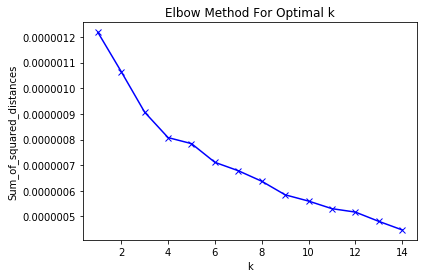

In [91]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

I used K-means algorithm and because the data of Average House Sales Price is not in the same range with the venues data i used Sklearn normalize algotithm on the entire DataFrame 

In [105]:

from sklearn import preprocessing  # to normalise existing X
#X_Norm = preprocessing.normalize(X)
# set number of clusters
kclusters = 8 #int(len(df["Neighborhood"].unique()) / 10)

Bucharest_grouped_clustering = Bucharest_grouped.drop('Neighborhood', 1)
Bucharest_grouped_clustering_x = preprocessing.normalize(Bucharest_grouped_clustering) 
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Bucharest_grouped_clustering_x)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 4, 7, 7, 4, 1, 7, 1, 5, 7, 1, 4, 1, 4, 7, 0, 1, 4, 1, 7, 1, 6,
       4, 3, 4, 0, 1, 6, 1, 1, 7, 1, 0, 0, 4, 7, 1, 1, 1, 0, 0, 4, 7, 4,
       2, 1, 4, 1, 1, 1, 1, 4, 1, 4, 7], dtype=int32)

In [106]:
# add clustering labels
#neighborhoods_venues_sorted.drop(neighborhoods_venues_sorted['Cluster Labels'])
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_
Bucharest_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Bucharest_merged = Bucharest_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Bucharest_merged.head() # check the last columns!

,Neighborhood,Average House Price,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,1 Mai,1690,44.471100,26.050000,Gym / Fitness Center,Supermarket,ATM,Bakery,Lebanese Restaurant,Fast Food Restaurant,Electronics Store,Pizza Place,Pub,Bus Station,0
1,13 Septembrie-Panduri,1250,44.427539,26.066529,Restaurant,Bar,Plaza,Lounge,Supermarket,Café,Romanian Restaurant,Italian Restaurant,Grocery Store,Gym / Fitness Center,4
2,Aviatiei,2060,44.482300,26.098100,Restaurant,Supermarket,Gym / Fitness Center,Hotel,Dessert Shop,Gym,Shopping Mall,Grocery Store,Steakhouse,Beer Garden,7
3,Andronache,1300,44.478500,26.150100,Turkish Restaurant,Café,Restaurant,Bus Station,Fried Chicken Joint,Fast Food Restaurant,Auto Dealership,Furniture / Home Store,Herbs & Spices Store,Middle Eastern Restaurant,7
4,Baicului,990,44.448100,26.149300,Supermarket,Park,Café,Fast Food Restaurant,Gym / Fitness Center,Bakery,Department Store,Burger Joint,Soccer Field,Italian Restaurant,1


Over the map of Bucharest generated by Folium i supraimposed markers colored based on their clusterisation that on click shows aditional information regarding the first most common venue and the average house sales price in that neighborhood.

In [107]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, MostCommonVenue, HSP in zip(Bucharest_merged['Latitude'], Bucharest_merged['Longitude'], Bucharest_merged['Neighborhood'], Bucharest_merged['Cluster Labels'], Bucharest_merged['1st Most Common Venue'], Bucharest_merged['Average House Price']):
    label = folium.Popup(str(poi) + ' Most Common Venue: ' + str(MostCommonVenue) + ' AHSP: ' + str(HSP) +'eur//m2' , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters